In [ ]:
#installing dependencies
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

     |████████████████████████████████| 276kB 5.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=3cc90ca3eaf334e2adc49c949d8cabeb2bb0f934bd26a3d93d062169ddc188a6
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 720kB/s 
     |████████████████████████████████| 2.2MB 4.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201210-cp36-none-any.whl size=44711 sha256=b142b72ae24ca5f8dd64cedde61aec167ca0fb64298a0a317275d6de1a5ec108
  Stored in directory: /root/.cache/pip/wheels/ab/ce/d3/0b7bccf09516b236307289c3a9ad80fcf37431eca5f6624486
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import glob
import pandas as pd
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd drive/MyDrive/
!ls

drive  sample_data


In [ ]:
# Defined a function to create a dictionary in a format accepted by detectron2
def get_cysts_dicts(img_dir):
    # load the JSON file
    json_file = os.path.join(img_dir, "via_final.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    # loop through the entries in the JSON file
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        # add file_name, image_id, height and width information to the records
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        annos = v["regions"]

        objs = []
        # one image can have multiple annotations, therefore this loop is needed
        for annotation in annos:
            # reformat the polygon information to fit the specifications
            anno = annotation["shape_attributes"]
            cx = anno["cx"]
            cy = anno["cy"]
            rx= anno["rx"]
            ry=anno["ry"]
            theta =anno["theta"]
            region_attributes = annotation["region_attributes"]["Cyst-type"]

            # specify the category_id to match with the class.

            if "Giardia" in region_attributes:
                category_id = 1
            elif "Crypto" in region_attributes:
                category_id = 0
            
            def ellipse_to_rectange(rx,ry,theta):
              ea = rx*math.cos(theta)
              eb = ry*math.sin(theta)
              ec = rx*math.sin(theta)
              ed = ry*math.cos(theta)
              width = math.sqrt(math.pow(ea,2)+math.pow(eb,2))*2
              height = math.sqrt(math.pow(ec,2)+math.pow(ed,2))*2
              return (width ,height)
            width , height = ellipse_to_rectange(rx,ry,theta)

            obj = {
                "bbox": [cx-width*0.5,cy-height*0.5,cx+width*0.5,cy+height*0.5],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [],
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

for d in ["train", "val"]:
  DatasetCatalog.register("cysts_" + d, lambda d=d: get_cysts_dicts("/content/drive/My Drive/cysts_dataset/"+d))
  MetadataCatalog.get("cysts_" + d).set(thing_classes=["Crypto", "Giardia"])
cysts_metadata = MetadataCatalog.get("cysts_train")

In [ ]:
!ls

drive  sample_data


/content/drive/My Drive/cysts_dataset/val/SS7.jpg


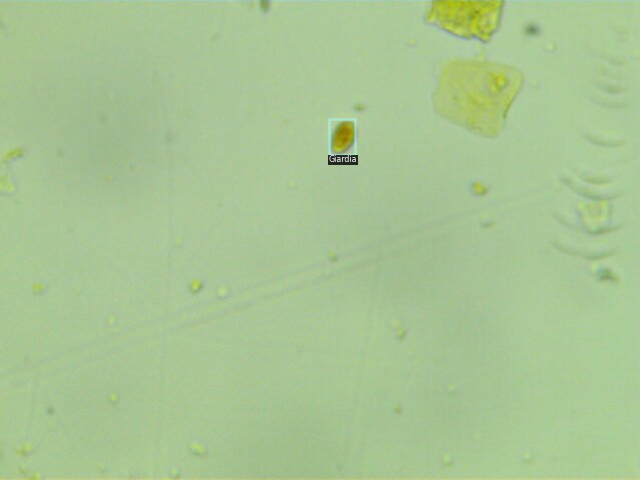

/content/drive/My Drive/cysts_dataset/val/243.jpg


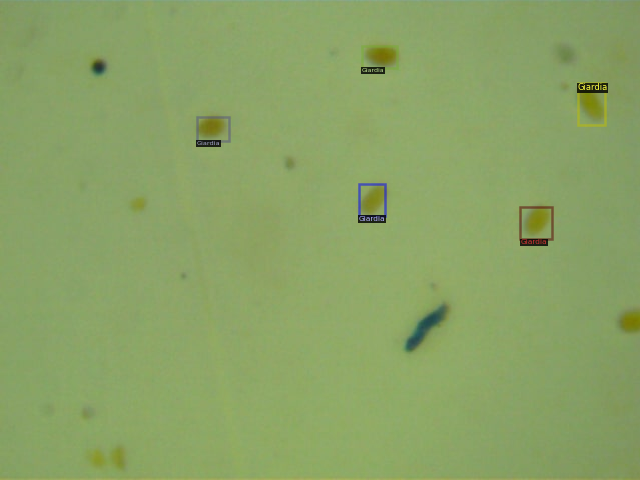

/content/drive/My Drive/cysts_dataset/val/251.jpg


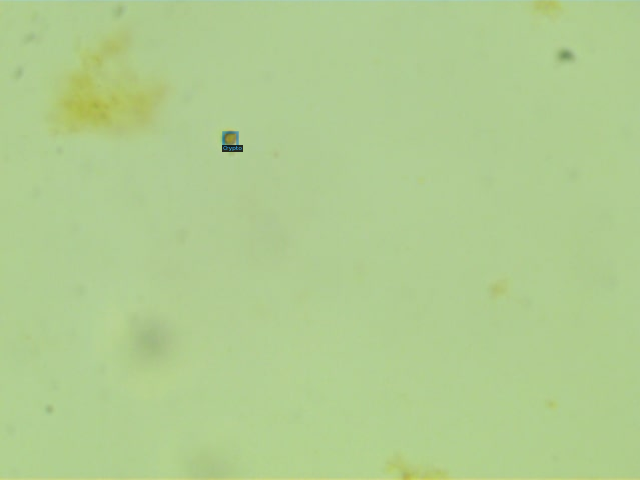

/content/drive/My Drive/cysts_dataset/val/245.jpg


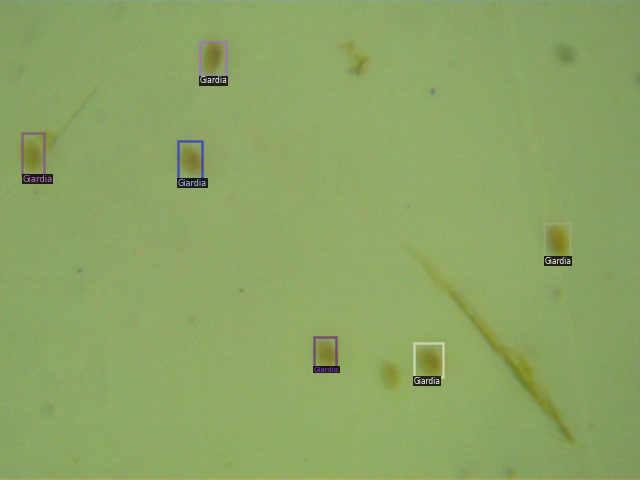

/content/drive/My Drive/cysts_dataset/val/241.jpg


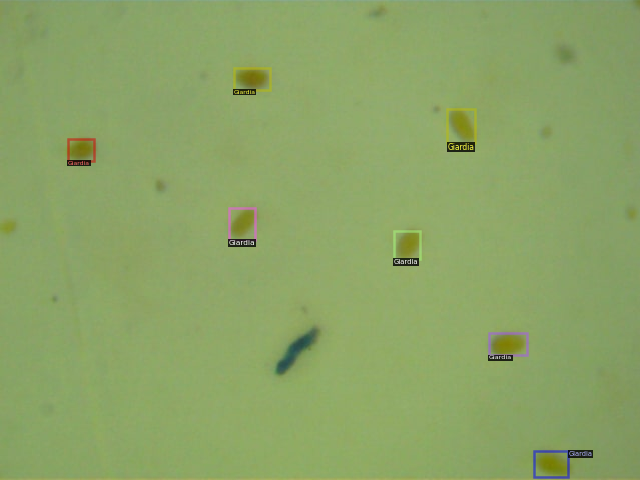

/content/drive/My Drive/cysts_dataset/val/247.jpg


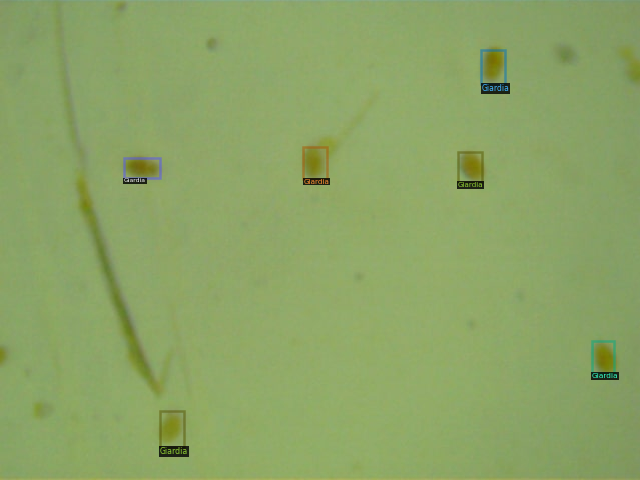

/content/drive/My Drive/cysts_dataset/val/246.jpg


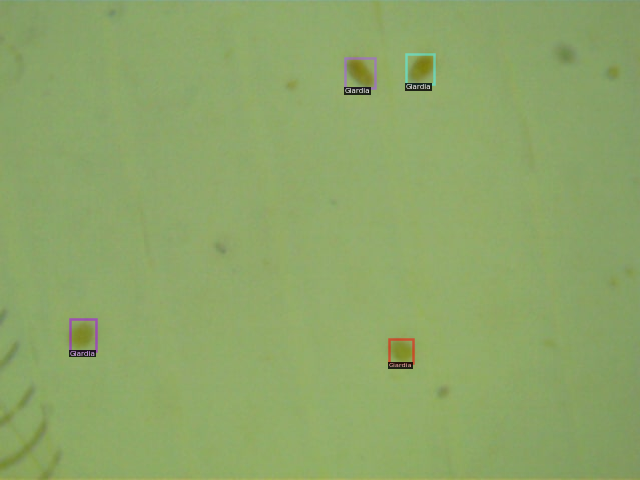

/content/drive/My Drive/cysts_dataset/val/250.jpg


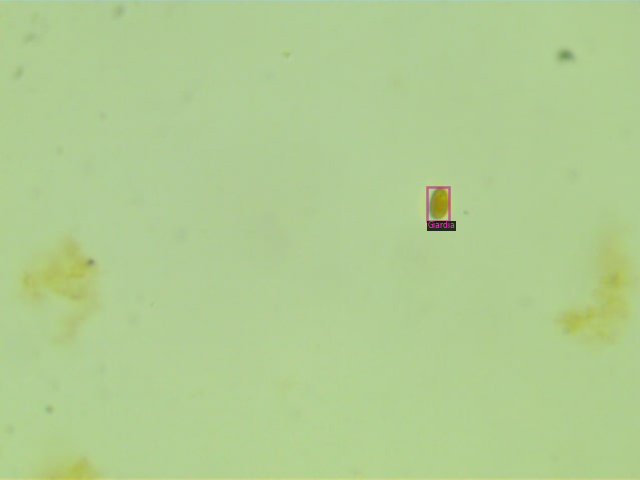

/content/drive/My Drive/cysts_dataset/val/239.jpg


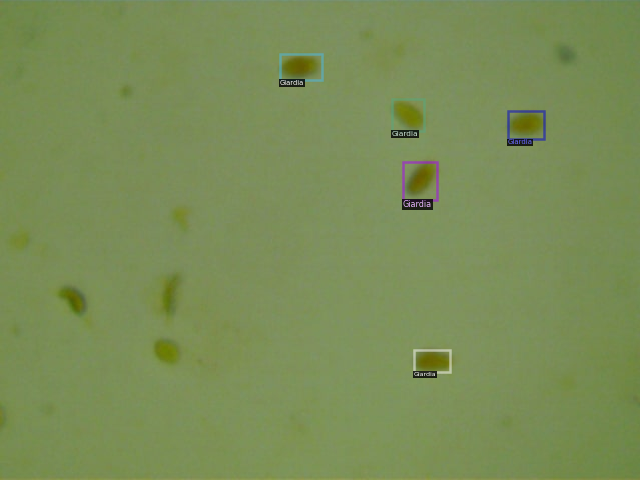

/content/drive/My Drive/cysts_dataset/val/242.jpg


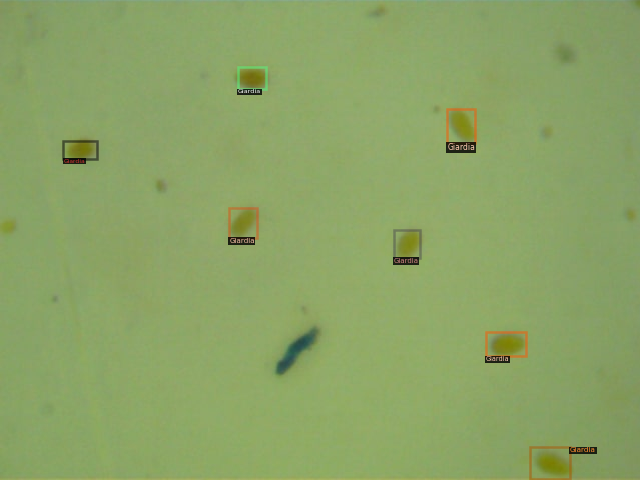

In [ ]:
dataset_dicts = get_cysts_dicts("/content/drive/My Drive/cysts_dataset/val")
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cysts_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Since detectron2 does not provide default evaluator, we create one. 
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder= None):

    if output_folder is None:
      os.makedirs("cysts_dataset/coco_eval", exist_ok = True)
      output_folder = "cysts_dataset/coco_eval"
    
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# creating an instance of config file and initializing model and model weight
cfg = get_cfg()

#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")

In [ ]:
# Use the registered dataset for training and validation 
cfg.DATASETS.TRAIN = ("cysts_train",)
cfg.DATASETS.TEST = ("cysts_val",)
cfg.DATALOADER.NUM_WORKERS = 4

In [ ]:
# we define following for convergence in optimizer
cfg.SOLVER.IMS_PER_BATCH =4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 400
cfg.SOLVER.MAX_ITER = 800
cfg.SOLVER.STEPS = (400,800)
cfg.SOLVER.GAMMA = 0.05

In [ ]:
# specify the number of classes and batch size per image
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.TEST.EVAL_PERIOD = 200

In [ ]:
!ls

drive  sample_data


In [ ]:
# Train the custom trainer
os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/10 16:45:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:36, 11.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.


[12/10 16:48:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:217: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[12/10 16:48:38 d2.utils.events]:  eta: 0:20:32  iter: 19  total_loss: 1.813  loss_cls: 1.116  loss_box_reg: 0.5794  loss_rpn_cls: 0.09707  loss_rpn_loc: 0.009445  time: 1.5491  data_time: 0.0363  lr: 4.8453e-05  max_mem: 9390M
[12/10 16:49:09 d2.utils.events]:  eta: 0:19:25  iter: 39  total_loss: 1.546  loss_cls: 0.6518  loss_box_reg: 0.8436  loss_rpn_cls: 0.009535  loss_rpn_loc: 0.01068  time: 1.5364  data_time: 0.0147  lr: 9.8403e-05  max_mem: 9390M
[12/10 16:49:41 d2.utils.events]:  eta: 0:19:13  iter: 59  total_loss: 1.344  loss_cls: 0.4895  loss_box_reg: 0.8245  loss_rpn_cls: 0.009178  loss_rpn_loc: 0.01396  time: 1.5512  data_time: 0.0157  lr: 0.00014835  max_mem: 9390M
[12/10 16:50:12 d2.utils.events]:  eta: 0:18:55  iter: 79  total_loss: 1.216  loss_cls: 0.3688  loss_box_reg: 0.8405  loss_rpn_cls: 0.00299  loss_rpn_loc: 0.009044  time: 1.5578  data_time: 0.0218  lr: 0.0001983  max_mem: 9390M
[12/10 16:50:44 d2.utils.events]:  eta: 0:18:26  iter: 99  total_loss: 1.064  loss_cls

In [ ]:
# Load weights and determine threshold for evaluation
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor= DefaultPredictor(cfg)
val_metadata = MetadataCatalog.get("cysts_val")

In [ ]:
# Run the evaluator with the train model
evaluator =COCOEvaluator("cysts_val", cfg, False, output_dir= "./output/")
val_loader = build_detection_test_loader(cfg,"cysts_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/10 17:09:34 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[12/10 17:09:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/10 17:09:34 d2.data.common]: Serializing 17 elements to byte tensors and concatenating them all ...
[12/10 17:09:34 d2.data.common]: Serialized dataset takes 0.01 MiB
[12/10 17:09:34 d2.evaluation.evaluator]: Start inference on 17 images
[12/10 17:09:36 d2.evaluation.evaluator]: Inference done 11/17. 0.1781 s / img. ETA=0:00:01
[12/10 17:09:37 d2.evaluation.evaluator]: Total inference time: 0:00:02.265089 (0.188757 s / img per device, on 1 devices)
[12/10 17:09:37 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.177343 s / img per device, on 1 devices)
[12/10 17:09:37 d2.evaluation.coco_evaluation]: Preparing results for COCO for

OrderedDict([('bbox',
              {'AP': 52.63732400865092,
               'AP-Crypto': 40.396039603960396,
               'AP-Giardia': 64.87860841334145,
               'AP50': 73.85607815139696,
               'AP75': 69.98753355336706,
               'APl': nan,
               'APm': nan,
               'APs': 52.72931840027096})])

/content/drive/My Drive/cysts_dataset/val/241.jpg


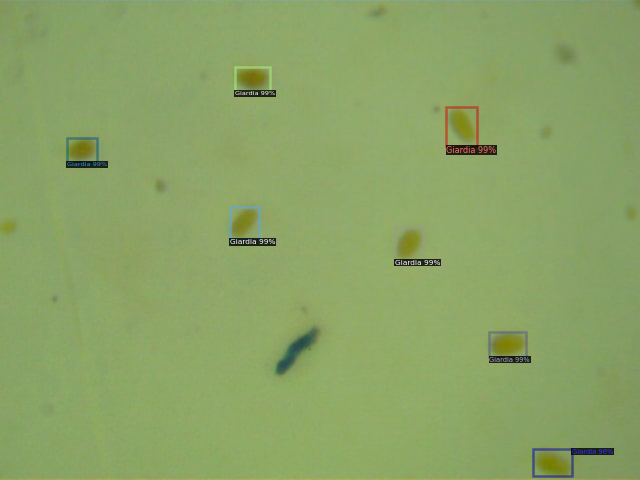

/content/drive/My Drive/cysts_dataset/val/240.jpg


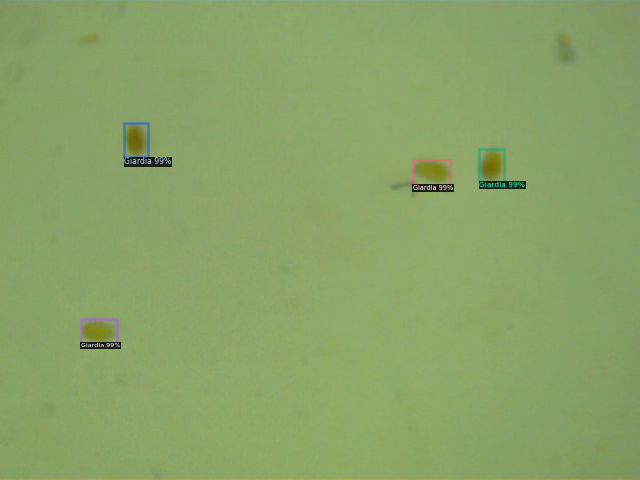

/content/drive/My Drive/cysts_dataset/val/242.jpg


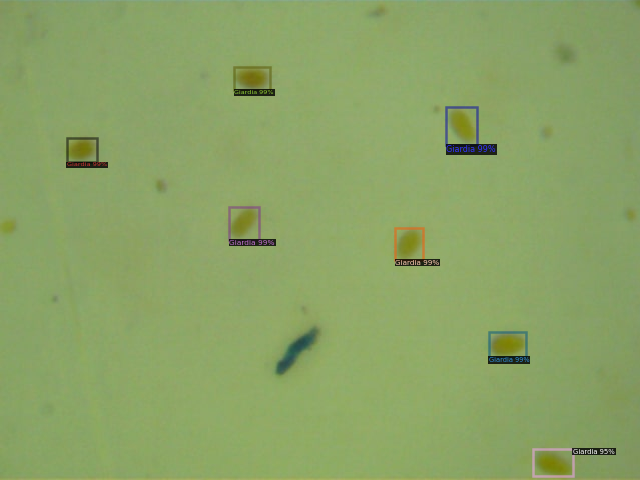

/content/drive/My Drive/cysts_dataset/val/247.jpg


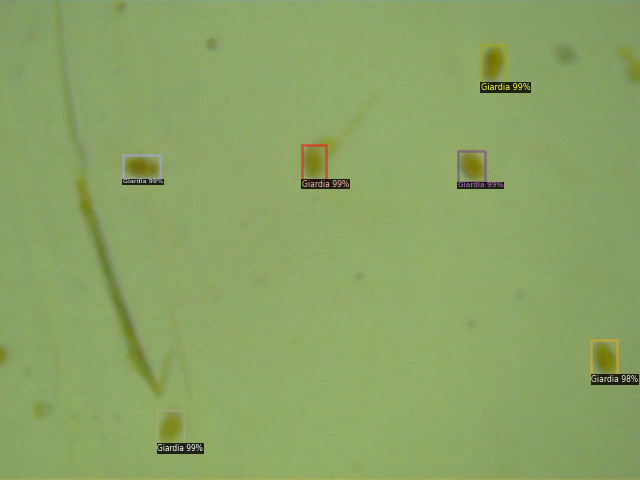

/content/drive/My Drive/cysts_dataset/val/243.jpg


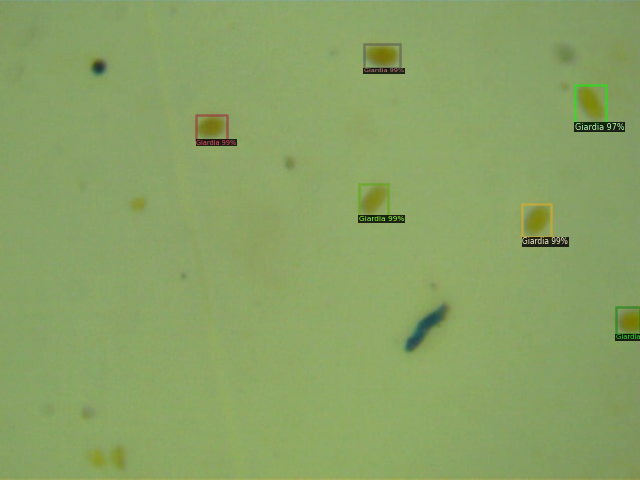

/content/drive/My Drive/cysts_dataset/val/244.jpg


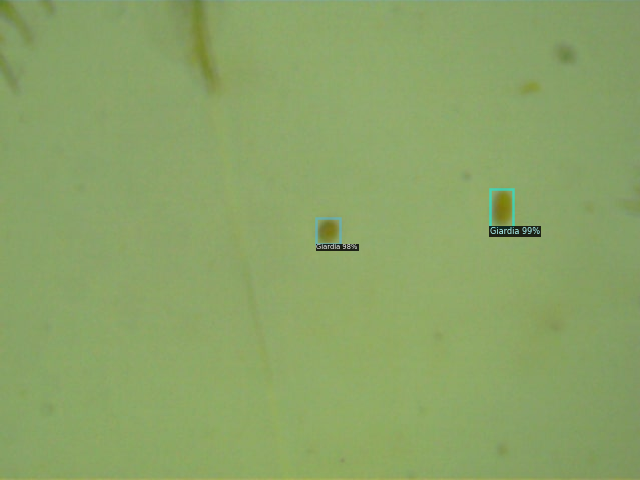

/content/drive/My Drive/cysts_dataset/val/248.jpg


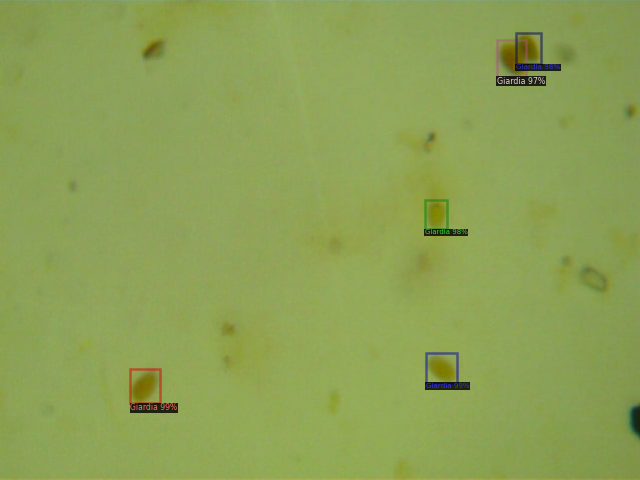

/content/drive/My Drive/cysts_dataset/val/246.jpg


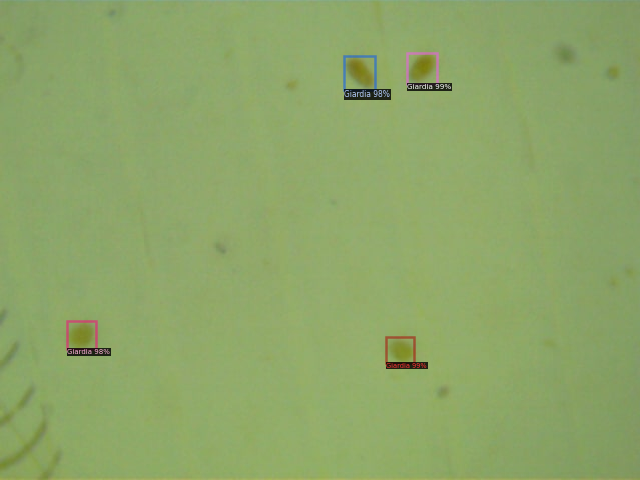

/content/drive/My Drive/cysts_dataset/val/245.jpg


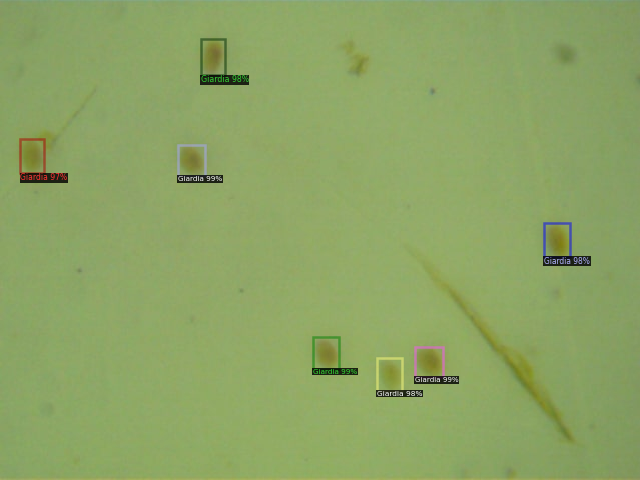

/content/drive/My Drive/cysts_dataset/val/249.jpg


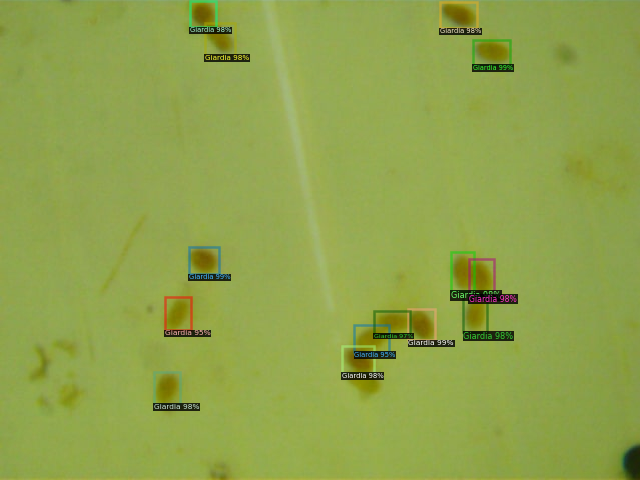

/content/drive/My Drive/cysts_dataset/val/250.jpg


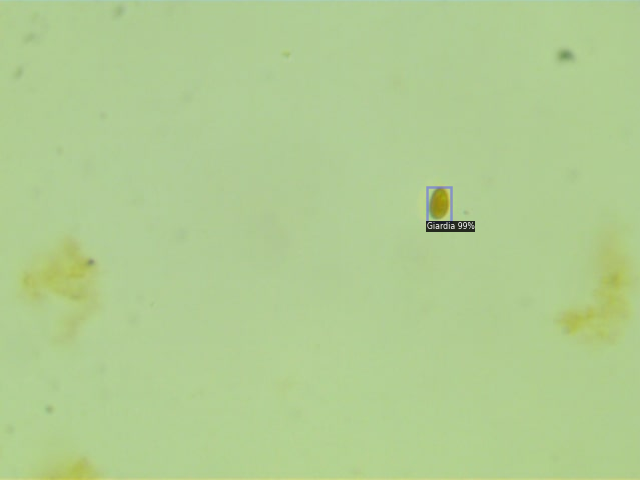

/content/drive/My Drive/cysts_dataset/val/251.jpg


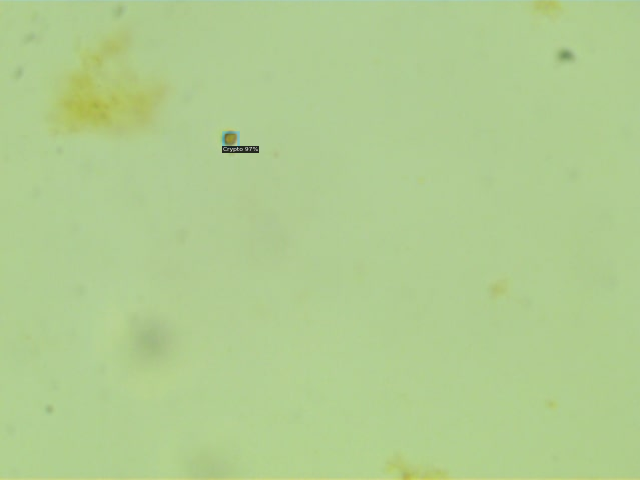

/content/drive/My Drive/cysts_dataset/val/252.jpg


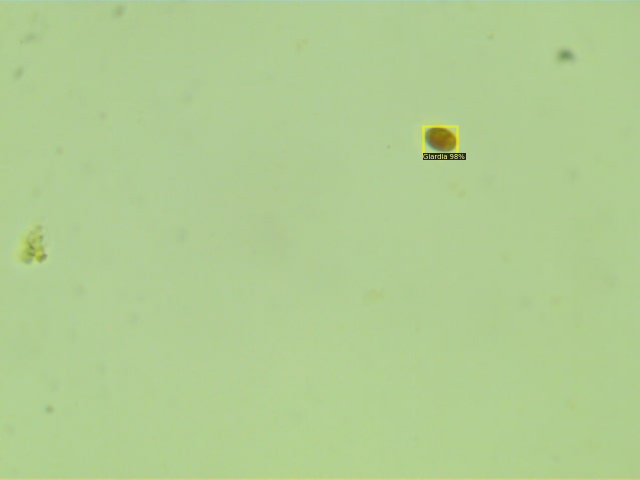

/content/drive/My Drive/cysts_dataset/val/253.jpg


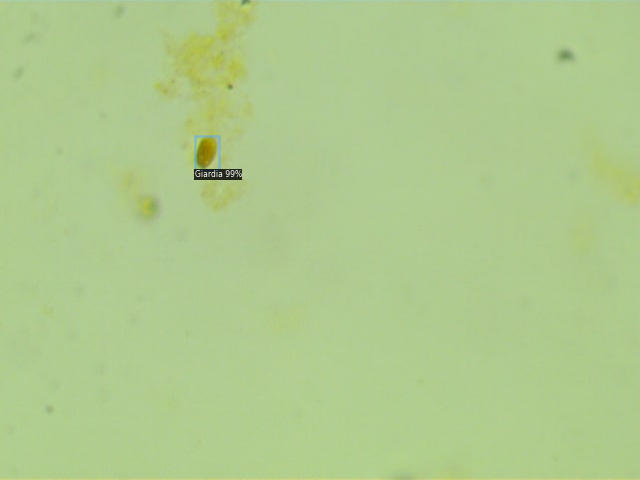

/content/drive/My Drive/cysts_dataset/val/239.jpg


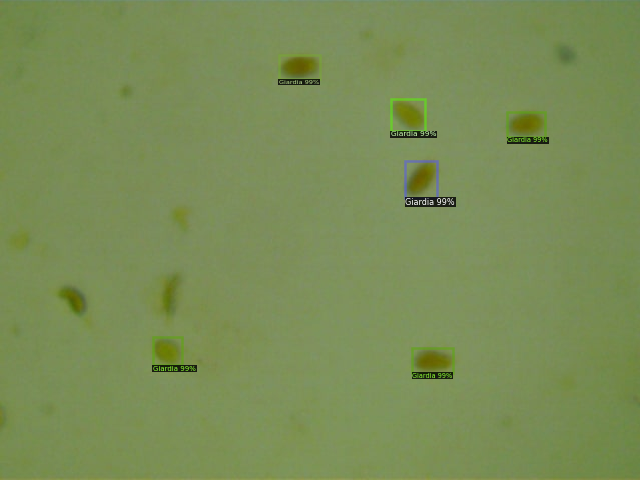

/content/drive/My Drive/cysts_dataset/val/238.jpg


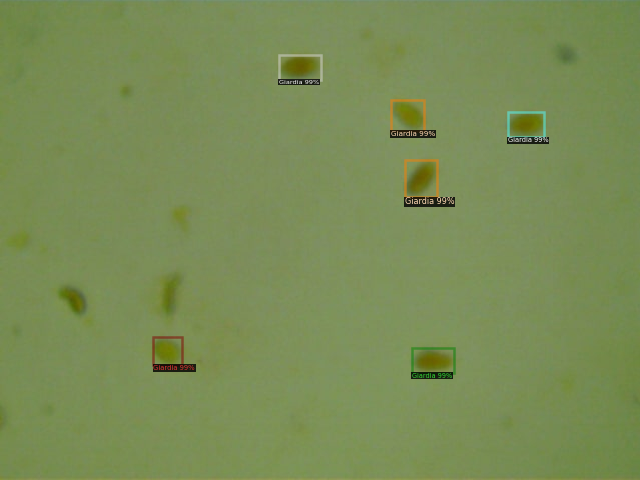

/content/drive/My Drive/cysts_dataset/val/SS7.jpg


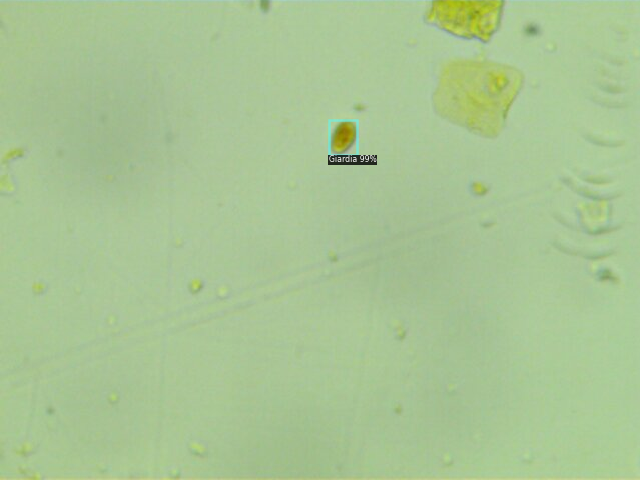

/content/drive/My Drive/cysts_dataset/val/255.jpg


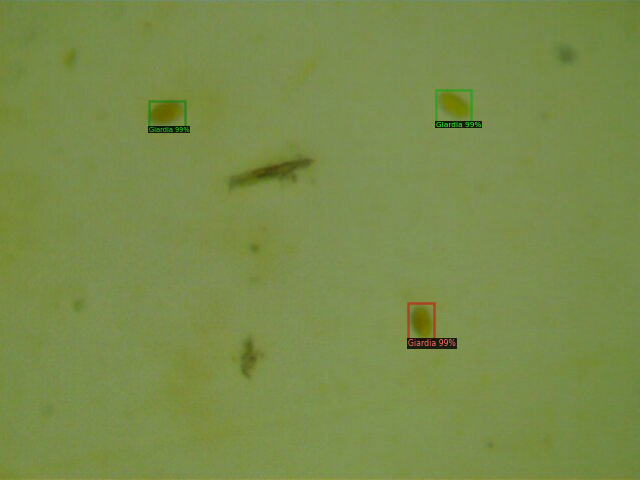

In [ ]:

for index, img_name in enumerate(glob.glob('/content/drive/My Drive/cysts_dataset/val/*.jpg')):
  print(img_name)
  im = cv2.imread(img_name)
  outputs = predictor(im)
  v= Visualizer(im[:, :, ::-1],
                metadata = val_metadata,
                scale = 1)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])